In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pymc as pm
import arviz as az

# The next libraries are to plot DAGs
import collections.abc
collections.Iterable = collections.abc.Iterable
from causalgraphicalmodels import CausalGraphicalModel

---

In [2]:
ALPHA_LEVEL = 0.11

In [3]:
Dat = pd.read_csv('Data/WaffleDivorce.csv', sep=';')

We standardize the variables

In [4]:
Dat['MedianAgeMarriageStandard'] = (Dat['MedianAgeMarriage'] - Dat['MedianAgeMarriage'].mean()) / Dat['MedianAgeMarriage'].std()
Dat['DivorceStandard'] = (Dat['Divorce'] - Dat['Divorce'].mean()) / Dat['Divorce'].std()
Dat['MarriageStandard'] = (Dat['Marriage'] - Dat['Marriage'].mean()) / Dat['Marriage'].std()

### Model to predict divorce rate given age at marriage

In [5]:
with pm.Model() as ModelDivorceGivenAge:
    Alpha = pm.Normal('Alpha', mu=0, sigma=0.2)
    BetaA = pm.Normal('BetaA', mu=0, sigma=0.5)
    Sigma = pm.Exponential('Sigma', lam=1)
    Mu = pm.Deterministic('Mu', Alpha + BetaA * Dat['MedianAgeMarriageStandard'])

    Divorce = pm.Normal('Divorce', mu=Mu, sigma=Sigma, observed=Dat['DivorceStandard'])

Check the priors

In [6]:
with ModelDivorceGivenAge:
    TraceDivorceGivenAge = pm.sample_prior_predictive()

Sampling: [Alpha, BetaA, Divorce, Sigma]


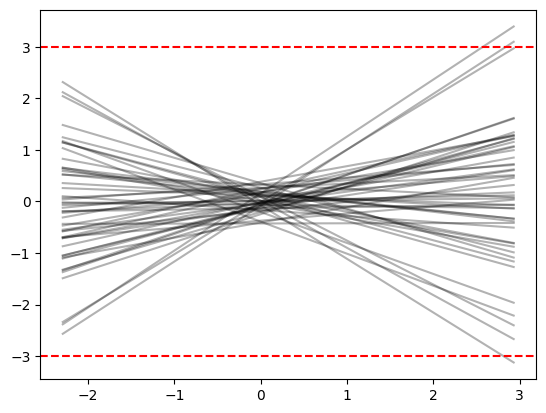

In [7]:
for a, b in zip(TraceDivorceGivenAge.prior.Alpha[0,:50], TraceDivorceGivenAge.prior.BetaA[0,:50]):
    _ = plt.plot(
        [Dat['MedianAgeMarriageStandard'].min(), Dat['MedianAgeMarriageStandard'].max()]
        , [a + b * Dat['MedianAgeMarriageStandard'].min(), a + b * Dat['MedianAgeMarriageStandard'].max()]
        , color='k'
        , alpha=0.3
    )
    
plt.axhline(3, linestyle='--', color='r')
plt.axhline(-3, linestyle='--', color='r')

We adjust the model

In [8]:
with ModelDivorceGivenAge:
    TraceDivorceGivenAge.extend(pm.sample())
    TraceDivorceGivenAge.extend(pm.sample_posterior_predictive(TraceDivorceGivenAge))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alpha, BetaA, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
/home/dmitri/.local/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
Sampling: [Divorce]


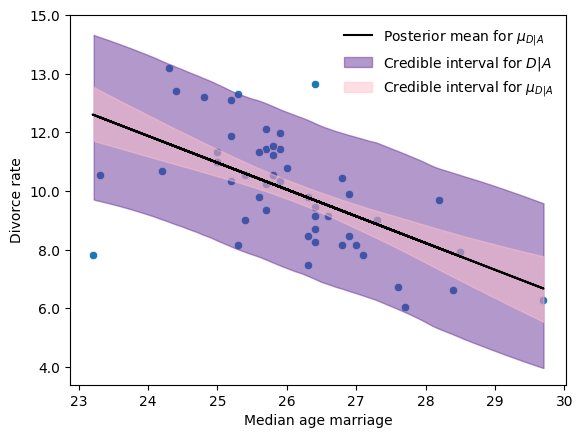

In [9]:
sns.scatterplot(x=Dat['MedianAgeMarriage'], y=Dat['DivorceStandard'])

plt.plot(
    Dat['MedianAgeMarriage']
    , TraceDivorceGivenAge.posterior.Mu.mean(('chain', 'draw'))
    , label=r"Posterior mean for $\mu_{D|A}$"
    , color='k'
)

az.plot_hdi(
    Dat['MedianAgeMarriage']
    , TraceDivorceGivenAge.posterior_predictive.Divorce
    , hdi_prob=1-ALPHA_LEVEL
    , color='rebeccapurple'
    , fill_kwargs={'alpha': 0.5, 'label': r"Credible interval for $D|A$"}
)

az.plot_hdi(
    Dat['MedianAgeMarriage']
    , TraceDivorceGivenAge.posterior.Mu
    , hdi_prob=1-ALPHA_LEVEL
    , color='pink'
    , fill_kwargs={'alpha': 0.5, 'label': r"Credible interval for $\mu_{D|A}$"}
)

plt.legend(frameon=False)
_ = plt.yticks(np.arange(-3, 4), np.round(np.arange(-3, 4) * Dat['Divorce'].std() + Dat['Divorce'].mean()))
_ = plt.xlabel("Median age marriage")
_ = plt.ylabel("Divorce rate")

Total effect of age over the divorce rate

In [10]:
az.summary(TraceDivorceGivenAge, var_names='BetaA', kind='stats', hdi_prob=1-ALPHA_LEVEL).round(2)

,mean,sd,hdi_5.5%,hdi_94.5%
BetaA,-0.57,0.12,-0.75,-0.38


### Model to predict divorce rate given marriage rate

In [11]:
with pm.Model() as ModelDivorceGivenMarriage:
    Alpha = pm.Normal('Alpha', mu=0, sigma=0.2)
    BetaM = pm.Normal('BetaM', mu=0, sigma=0.5)
    Sigma = pm.Exponential('Sigma', lam=1)
    Mu = pm.Deterministic('Mu', Alpha + BetaM * Dat['MarriageStandard'])

    Divorce = pm.Normal('Divorce', mu=Mu, sigma=Sigma, observed=Dat['DivorceStandard'])

We adjust the model

In [12]:
with ModelDivorceGivenMarriage:
    TraceDivorceGivenMarriage = pm.sample()
    TraceDivorceGivenMarriage.extend(pm.sample_posterior_predictive(TraceDivorceGivenMarriage))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alpha, BetaM, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [Divorce]


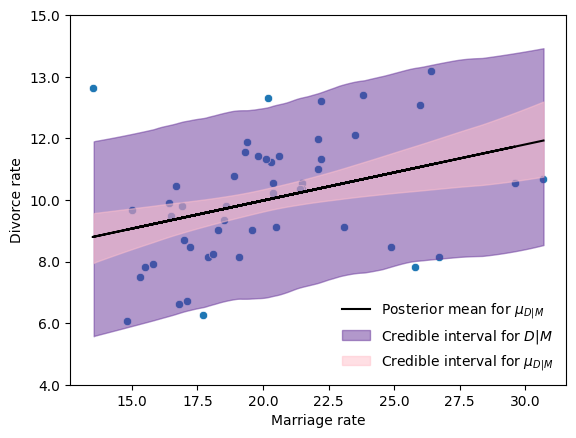

In [13]:
sns.scatterplot(x=Dat['Marriage'], y=Dat['DivorceStandard'])

plt.plot(
    Dat['Marriage']
    , TraceDivorceGivenMarriage.posterior.Mu.mean(('chain', 'draw'))
    , label=r"Posterior mean for $\mu_{D|M}$"
    , color='k'
)

az.plot_hdi(
    Dat['Marriage']
    , TraceDivorceGivenMarriage.posterior_predictive.Divorce
    , hdi_prob=1-ALPHA_LEVEL
    , color='rebeccapurple'
    , fill_kwargs={'alpha': 0.5, 'label': r"Credible interval for $D|M$"}
)

az.plot_hdi(
    Dat['Marriage']
    , TraceDivorceGivenMarriage.posterior.Mu
    , hdi_prob=1-ALPHA_LEVEL
    , color='pink'
    , fill_kwargs={'alpha': 0.5, 'label': r"Credible interval for $\mu_{D|M}$"}
)

plt.legend(frameon=False)
_ = plt.yticks(np.arange(-3, 4), np.round(np.arange(-3, 4) * Dat['Divorce'].std() + Dat['Divorce'].mean()))
_ = plt.xlabel("Marriage rate")
_ = plt.ylabel("Divorce rate")

Total effect of marriage rate over the divorce rate

In [14]:
az.summary(TraceDivorceGivenMarriage, var_names='BetaM', kind='stats', hdi_prob=1-ALPHA_LEVEL).round(2)

,mean,sd,hdi_5.5%,hdi_94.5%
BetaM,0.35,0.13,0.14,0.56


---

However, the causal influence between the variables might be given by the following DAG

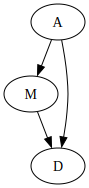

In [15]:
Dag = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M"), ("M", "D")])
Dag.draw()

We may want to think **causally**. 

Few interesting assumptions (or rather deductions):

* a) Age has a direct impact on Divorce rate as people may grow incompatible with the parter 

* b) Marriage Rate has a direct impact on Divorce rate for obvious reason (more marriages => more divorce)

* c) Finally, Age has an indirect effect. If people get married earlier, then the marriage rate may increase, because there are mmore young people.

We can get the joint probability distribution implied by our causal graphical model using

In [16]:
print(Dag.get_distribution())

P(A)P(M|A)P(D|A,M)


Thus, we need to calculate two more regression models.

### Model to predict marriage rate given age at marriage

In [17]:
with pm.Model() as ModelMarriageGivenAge:
    Alpha = pm.Normal('Alpha', mu=0, sigma=0.2)
    BetaAM = pm.Normal('BetaAM', mu=0, sigma=0.5)
    Sigma = pm.Exponential('Sigma', lam=1)
    Mu = pm.Deterministic('Mu', Alpha + BetaAM * Dat['MedianAgeMarriageStandard'])

    Marriage = pm.Normal('Marriage', mu=Mu, sigma=Sigma, observed=Dat['MarriageStandard'])

We adjust the model

In [18]:
with ModelMarriageGivenAge:
    TraceMarriageGivenAge = pm.sample()
    TraceMarriageGivenAge.extend(pm.sample_posterior_predictive(TraceMarriageGivenAge))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alpha, BetaAM, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [Marriage]


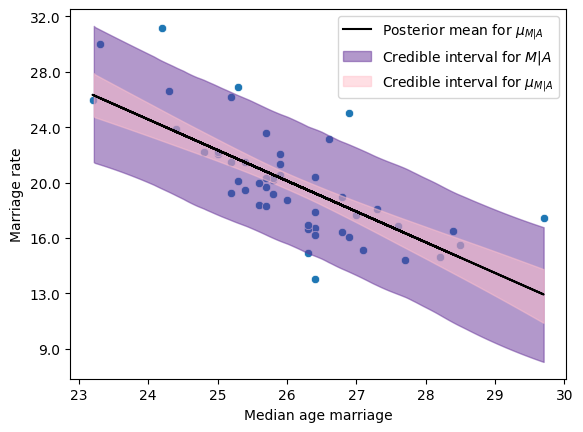

In [19]:
sns.scatterplot(x=Dat['MedianAgeMarriage'], y=Dat['MarriageStandard'])

plt.plot(
    Dat['MedianAgeMarriage']
    , TraceMarriageGivenAge.posterior.Mu.mean(('chain', 'draw'))
    , label=r"Posterior mean for $\mu_{M|A}$"
    , color='k'
)

az.plot_hdi(
    Dat['MedianAgeMarriage']
    , TraceMarriageGivenAge.posterior_predictive.Marriage
    , hdi_prob=1-ALPHA_LEVEL
    , color='rebeccapurple'
    , fill_kwargs={'alpha': 0.5, 'label': r"Credible interval for $M|A$"}
)

az.plot_hdi(
    Dat['MedianAgeMarriage']
    , TraceMarriageGivenAge.posterior.Mu
    , hdi_prob=1-ALPHA_LEVEL
    , color='pink'
    , fill_kwargs={'alpha': 0.5, 'label': r"Credible interval for $\mu_{M|A}$"}
)

plt.legend()
_ = plt.yticks(np.arange(-3, 4), np.round(np.arange(-3, 4) * Dat['Marriage'].std() + Dat['Marriage'].mean()))
_ = plt.xlabel("Median age marriage")
_ = plt.ylabel("Marriage rate")

Direct effect age of marriage on marriage rate

In [20]:
az.summary(TraceMarriageGivenAge, var_names='BetaAM', kind='stats', hdi_prob=1-ALPHA_LEVEL).round(2)

,mean,sd,hdi_5.5%,hdi_94.5%
BetaAM,-0.69,0.1,-0.84,-0.53


### Model to predict divorce rate given marriage rate and age marriage

In [21]:
with pm.Model() as ModelDivorceGivenMarriageAndAge:
    Alpha = pm.Normal('Alpha', mu=0, sigma=0.2)
    BetaM = pm.Normal('BetaM', mu=0, sigma=0.5)
    BetaA = pm.Normal('BetaA', mu=0, sigma=0.5)
    Sigma = pm.Exponential('Sigma', lam=1)
    Mu = pm.Deterministic('Mu', Alpha + BetaM * Dat['MarriageStandard'] + BetaA * Dat['MedianAgeMarriageStandard'])

    Divorce = pm.Normal('Divorce', mu=Mu, sigma=Sigma, observed=Dat['DivorceStandard'])

We adjust the model

In [22]:
with ModelDivorceGivenMarriageAndAge:
    TraceDivorceGivenMarriageAndAge = pm.sample()
    TraceDivorceGivenMarriageAndAge.extend(pm.sample_posterior_predictive(TraceDivorceGivenMarriageAndAge))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alpha, BetaM, BetaA, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
Sampling: [Divorce]


Direct effect of marriage rate and age of marriage on divorce rate

In [23]:
az.summary(TraceDivorceGivenMarriageAndAge, var_names=['BetaA', 'BetaM'], kind='stats', hdi_prob=1-ALPHA_LEVEL).round(2)

,mean,sd,hdi_5.5%,hdi_94.5%
BetaA,-0.61,0.16,-0.87,-0.37
BetaM,-0.06,0.16,-0.30,0.20


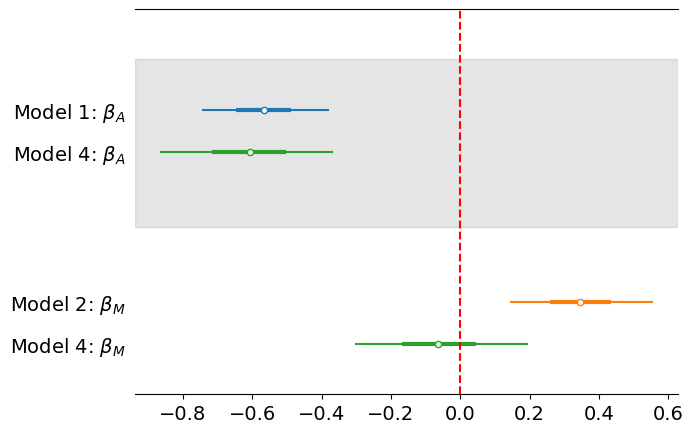

In [24]:
import arviz.labels as azl

labeller = azl.MapLabeller(var_name_map = {"BetaA": r"$\beta_A$", "BetaM": r"$\beta_M$"})

ax = az.plot_forest(
    [TraceDivorceGivenAge, TraceDivorceGivenMarriage, TraceDivorceGivenMarriageAndAge]
    , model_names = ["Model 1", "Model 2", "Model 4"]
    , var_names=['BetaA', 'BetaM']
    , combined=True
    , figsize=(7,5)
    , labeller=labeller
    , legend=False
    , hdi_prob=1-ALPHA_LEVEL
)

ax[0].set_title('')
plt.axvline(0, color='r', linestyle='--')

# plt.savefig('DivorcePlotForest.png', transparent=True, bbox_inches='tight')

Thus, the causal graph is almost the next one

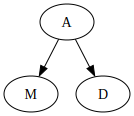

In [25]:
Dag2 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M")])
Dag2.draw()

### 

To see the Conditional Independencies

In [26]:
Dag2.get_all_independence_relationships()

[('M', 'D', {'A'})]

The explanation is that **M** and **D** are not independent, unless we condition on **A** when they become conditionally independent.

---

Residual plots

Consider the residuals of the marriage age given the median age. These residuals is the variation of marriage rate that is left over, after knowing the median age. Thus, we can plot the divorce rate against these residuals. This plot would display the linear relationship between divorce and marriage rates, having conditioned already on median age of marriage.

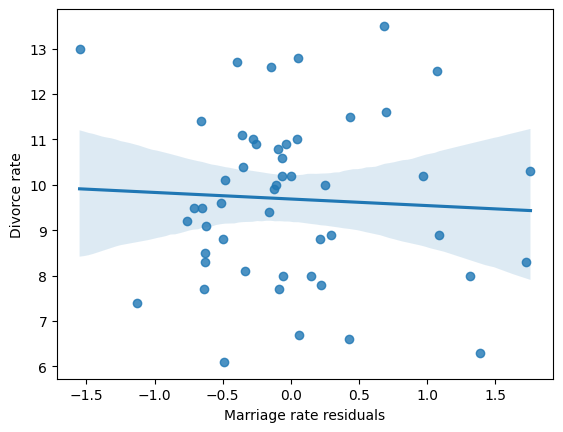

In [27]:
Dat['MarriageStandardResiduals'] = Dat['MarriageStandard'] - TraceMarriageGivenAge.posterior.Mu.mean(axis=(0,1))
sns.regplot(Dat, x='MarriageStandardResiduals', y='Divorce')

_ = plt.xlabel("Marriage rate residuals")
_ = plt.ylabel("Divorce rate")

We get the other residual plot

In [28]:
with pm.Model() as ModelAgeGivenMarriage:
    Alpha = pm.Normal('Alpha', mu=0, sigma=0.2)
    BetaMA = pm.Normal('BetaAM', mu=0, sigma=0.5)
    Sigma = pm.Exponential('Sigma', lam=1)
    Mu = pm.Deterministic('Mu', Alpha + BetaMA * Dat['MarriageStandard'])

    Age = pm.Normal('Age', mu=Mu, sigma=Sigma, observed=Dat['MedianAgeMarriageStandard'])

    TraceAgeGivenMarriage = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alpha, BetaAM, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


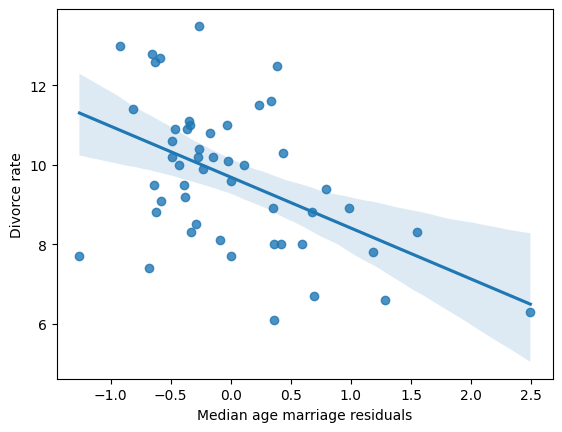

In [29]:
Dat['MedianAgeMarriageStandardResiduals'] = Dat['MedianAgeMarriageStandard'] - TraceAgeGivenMarriage.posterior.Mu.mean(axis=(0,1))
sns.regplot(Dat, x='MedianAgeMarriageStandardResiduals', y='Divorce')

_ = plt.xlabel("Median age marriage residuals")
_ = plt.ylabel("Divorce rate")

---

Posterior predictive plot

In [30]:
DivorcePosteriorPredictive = az.summary(
    TraceDivorceGivenMarriageAndAge
    , kind='stats'
    , group='posterior_predictive'
    , hdi_prob=1-ALPHA_LEVEL
).reset_index(drop=True)

In [31]:
Dat = pd.concat([Dat, DivorcePosteriorPredictive], axis=1)

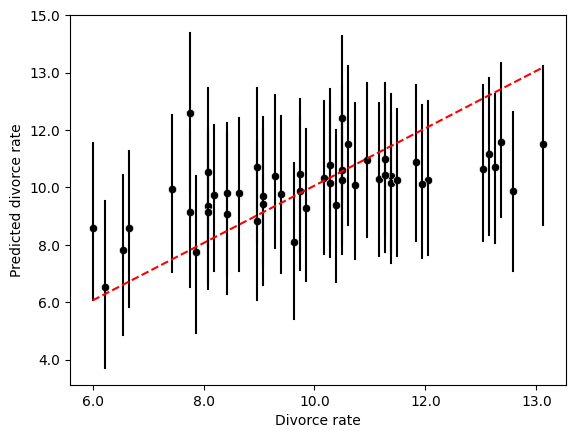

In [32]:
sns.scatterplot(data=Dat, x='DivorceStandard', y='mean', color='k')

for i in range(len(Dat)):
    plt.plot(
        [Dat.loc[i, 'DivorceStandard'], Dat.loc[i, 'DivorceStandard']]
        , [Dat.loc[i, 'hdi_' + str((ALPHA_LEVEL / 2) * 100) + '%'], Dat.loc[i, 'hdi_' + str((1 - ALPHA_LEVEL / 2) * 100) + '%']]
        , color='k'
    )
    
plt.plot(
    [Dat['DivorceStandard'].min(), Dat['DivorceStandard'].max()]
    , [Dat['DivorceStandard'].min(), Dat['DivorceStandard'].max()]
    , color='r'
    , linestyle='--'
)

_ = plt.xlabel("Divorce rate")
_ = plt.ylabel("Predicted divorce rate")
_ = plt.yticks(np.arange(-3, 4), np.round(np.arange(-3, 4) * Dat['Divorce'].std() + Dat['Divorce'].mean()))
_ = plt.xticks(
    np.arange(Dat['DivorceStandard'].min(), Dat['DivorceStandard'].max())
    , np.round(np.arange(Dat['DivorceStandard'].min(), Dat['DivorceStandard'].max()) * Dat['Divorce'].std() + Dat['Divorce'].mean())
)

---

Counterfactual plots

Consider again the following DAG

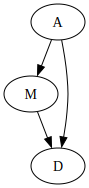

In [33]:
Dag.draw()

We define the causal model

In [34]:
with pm.Model() as ModelCausal:

    AgeData = pm.MutableData('AgeData', Dat['MedianAgeMarriageStandard'].to_numpy())
    MarriageData = pm.MutableData('MarriageData', Dat['MarriageStandard'].to_numpy())

    # A -> M
    AlphaAM = pm.Normal('AlphaAM', mu=0, sigma=0.2)
    BetaAM = pm.Normal('BetaAM', mu=0, sigma=0.5)
    SigmaAM = pm.Exponential('SigmaAM', lam=1)
    MuAM = pm.Deterministic('MuAM', AlphaAM + BetaAM * AgeData)

    Marriage = pm.Normal('Marriage', mu=MuAM, sigma=SigmaAM, observed=MarriageData)

    # A -> D <- M
    Alpha = pm.Normal('Alpha', mu=0, sigma=0.2)
    BetaM = pm.Normal('BetaM', mu=0, sigma=0.5)
    BetaA = pm.Normal('BetaA', mu=0, sigma=0.5)
    Sigma = pm.Exponential('Sigma', lam=1)
    Mu = pm.Deterministic('Mu', Alpha + BetaM * MarriageData + BetaA * AgeData)

    Divorce = pm.Normal('Divorce', mu=Mu, sigma=Sigma, observed=Dat['DivorceStandard'])

In [ ]:
pm.model_to_graphviz(ModelCausal)

In [35]:
#pm.model_to_graphviz(ModelCausal).render(filename='CausalModelDivorce', format='png')

'CausalModelDivorce.png'

In [36]:
with ModelCausal:
    TraceCausal = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [AlphaAM, BetaAM, SigmaAM, Alpha, BetaM, BetaA, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


---

Counterfactual inference

Manipulating the median age at marriage

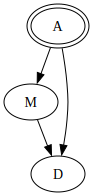

In [37]:
Dag.do('A').draw()

In [38]:
AgeCounterfactual = np.linspace(Dat['MedianAgeMarriageStandard'].min(), Dat['MedianAgeMarriageStandard'].max())

In [39]:
with ModelCausal:
    pm.set_data({'AgeData': AgeCounterfactual})
    Counterfactual = pm.sample_posterior_predictive(TraceCausal)

Sampling: [Divorce, Marriage]


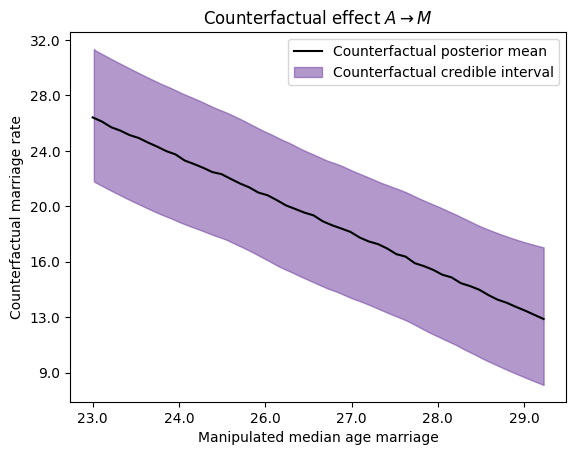

In [40]:
plt.plot(
    AgeCounterfactual
    , Counterfactual.posterior_predictive.Marriage.mean(('chain', 'draw'))
    , label="Counterfactual posterior mean"
    , color='k'
)

az.plot_hdi(
    AgeCounterfactual
    , Counterfactual.posterior_predictive.Marriage
    , hdi_prob=1-ALPHA_LEVEL
    , color='rebeccapurple'
    , fill_kwargs={'alpha': 0.5, 'label':"Counterfactual credible interval"}
)

plt.legend()
_ = plt.yticks(np.arange(-3, 4), np.round(np.arange(-3, 4) * Dat['Marriage'].std() + Dat['Marriage'].mean()))
_ = plt.xticks(
    np.arange(Dat['MedianAgeMarriageStandard'].min(), Dat['MedianAgeMarriageStandard'].max()),
    np.round(
        np.arange(Dat['MedianAgeMarriageStandard'].min(), Dat['MedianAgeMarriageStandard'].max()) * Dat['MedianAgeMarriage'].std() + Dat['MedianAgeMarriage'].mean()
    )
)
_ = plt.xlabel("Manipulated median age marriage")
_ = plt.ylabel("Counterfactual marriage rate")
_ = plt.title(r"Counterfactual effect $A\rightarrow M$")

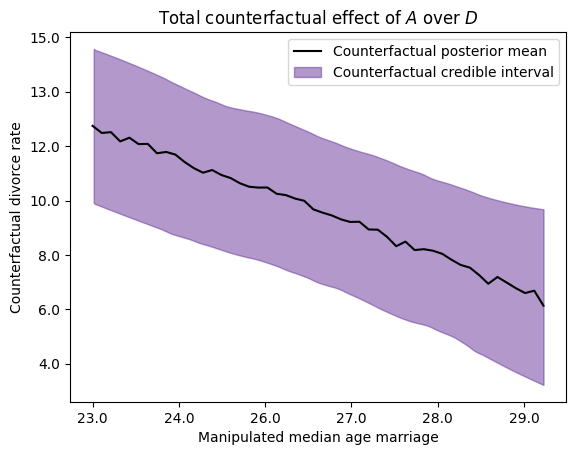

In [41]:
plt.plot(
    AgeCounterfactual
    , Counterfactual.posterior_predictive.Divorce.mean(('chain', 'draw'))
    , label="Counterfactual posterior mean"
    , color='k'
)

az.plot_hdi(
    AgeCounterfactual
    , Counterfactual.posterior_predictive.Divorce
    , hdi_prob=1-ALPHA_LEVEL
    , color='rebeccapurple'
    , fill_kwargs={'alpha': 0.5, 'label':"Counterfactual credible interval"}
)

plt.legend()
_ = plt.yticks(np.arange(-3, 4), np.round(np.arange(-3, 4) * Dat['Divorce'].std() + Dat['Divorce'].mean()))
_ = plt.xticks(
    np.arange(Dat['MedianAgeMarriageStandard'].min(), Dat['MedianAgeMarriageStandard'].max()),
    np.round(
        np.arange(Dat['MedianAgeMarriageStandard'].min(), Dat['MedianAgeMarriageStandard'].max()) * Dat['MedianAgeMarriage'].std() + Dat['MedianAgeMarriage'].mean()
    )
)
_ = plt.xlabel("Manipulated median age marriage")
_ = plt.ylabel("Counterfactual divorce rate")
_ = plt.title(r"Total counterfactual effect of $A$ over $D$")

What is the expected causal effect of decreasing the median age at marriage from 30 to 20?

In [42]:
AgeCounterfactual = (np.linspace(20, 30) - Dat['MedianAgeMarriage'].mean()) / Dat['MedianAgeMarriage'].std()

In [43]:
with ModelCausal:
    pm.set_data({'AgeData': AgeCounterfactual})
    Counterfactual = pm.sample_posterior_predictive(TraceCausal)

Sampling: [Divorce, Marriage]


In [44]:
# Marriage rate making the median age at marriage = 20
MarriageDoAge20 =  Counterfactual.posterior_predictive.Marriage[:,:,0].mean().values * Dat['Marriage'].std() + Dat['Marriage'].mean()

# Marriage rate making the median age at marriage = 30
MarriageDoAge30 =  Counterfactual.posterior_predictive.Marriage[:,:,-1].mean().values * Dat['Marriage'].std() + Dat['Marriage'].mean()

In [45]:
MarriageDoAge20, MarriageDoAge30, MarriageDoAge20 - MarriageDoAge30

(32.8916950632962, 11.71536760347517, 21.176327459821024)

In [46]:
# Marriage rate making the median age at marriage = 20
DivorceDoAge20 =  Counterfactual.posterior_predictive.Divorce[:,:,0].mean().values * Dat['Divorce'].std() + Dat['Divorce'].mean()

# Marriage rate making the median age at marriage = 30
DivorceDoAge30 =  Counterfactual.posterior_predictive.Divorce[:,:,-1].mean().values * Dat['Divorce'].std() + Dat['Divorce'].mean()

In [47]:
DivorceDoAge20, DivorceDoAge30, DivorceDoAge20 - DivorceDoAge30

(15.022076596415976, 5.899116297128042, 9.122960299287934)

---

Manipulating the marriage rate

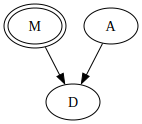

In [48]:
Dag.do('M').draw()

In [49]:
with ModelCausal:
    pm.set_data({'AgeData': AgeCounterfactual})
    Counterfactual = pm.sample_posterior_predictive(TraceCausal)

Sampling: [Divorce, Marriage]


In [50]:
AgeCounterfactual = np.array([0]*50)
MarriageCounterfactual = np.linspace(Dat['MarriageStandard'].min(), Dat['MarriageStandard'].max(), 50)

In [51]:
with ModelCausal:
    pm.set_data({'AgeData': AgeCounterfactual, 'MarriageData': MarriageCounterfactual})
    Counterfactual = pm.sample_posterior_predictive(TraceCausal, var_names=['Divorce'])

Sampling: [Divorce]


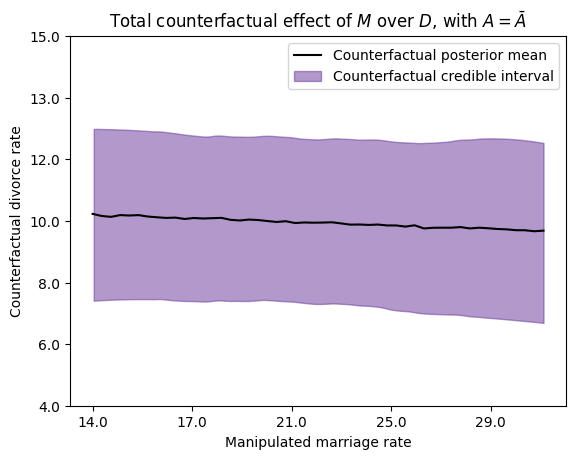

In [53]:
plt.plot(
    MarriageCounterfactual
    , Counterfactual.posterior_predictive.Divorce.mean(('chain', 'draw'))
    , label="Counterfactual posterior mean"
    , color='k'
)

az.plot_hdi(
    MarriageCounterfactual
    , Counterfactual.posterior_predictive.Divorce
    , hdi_prob=1-ALPHA_LEVEL
    , color='rebeccapurple'
    , fill_kwargs={'alpha': 0.5, 'label':"Counterfactual credible interval"}
)

plt.legend()
_ = plt.yticks(np.arange(-3, 4), np.round(np.arange(-3, 4) * Dat['Divorce'].std() + Dat['Divorce'].mean()))
_ = plt.xticks(
    np.arange(Dat['MarriageStandard'].min(), Dat['MarriageStandard'].max()),
    np.round(
        np.arange(Dat['MarriageStandard'].min(), Dat['MarriageStandard'].max()) * Dat['Marriage'].std() + Dat['Marriage'].mean()
    )
)
_ = plt.xlabel("Manipulated marriage rate")
_ = plt.ylabel("Counterfactual divorce rate")
_ = plt.title(r"Total counterfactual effect of $M$ over $D$, with $A=\bar{A}$")